In [1]:
import torch
import geoopt
from geoopt.optim import RiemannianSGD, RiemannianAdam
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from torchvision.transforms.functional import rotate

import numpy as np
from torch.func import grad
from scipy.linalg import lstsq, null_space

In [2]:
## Questo è il notebook dove facciamo le cose sul primo layer
## + layer retraction non esatta

TODO:
* controllare se comb lin di vettori del kernel è in media sempre lo stesso vettore
* riuscirci

$$P^\parallel=D(D^tD)^{-1}D^t$$

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


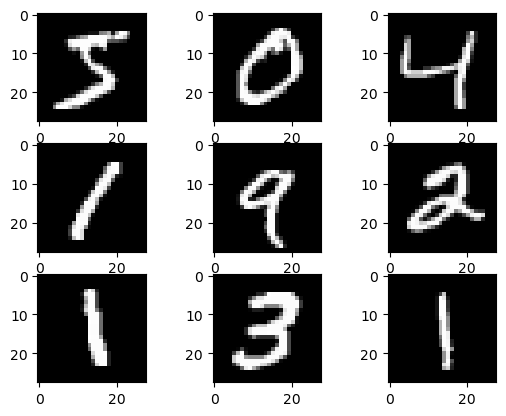

In [2]:
# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()
trainX = trainX/255
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

In [3]:
def G(d): # questa è  rot_mat
    mat = np.zeros(d**4).reshape(d**2,d**2)
    for j in range(d):
        for i in range(d):
            k = (i+1)*d-j
            h = i+(j)*d+1

            mat[h-1][k-1] = 1
    return mat

def W(output_dim, d = 4):
    kernel = null_space((np.identity(d*d) -  G(d)).T).T
    W = []
    for j in range(output_dim):
        vec = np.zeros(d**2)
        for k in kernel:
            vec = (np.random.random()-0.5)*2*k + vec # kernel[j]
        W.append(list(vec/np.linalg.norm(vec)))
    W = np.array(W)
    return np.array(W)

def projector(d = 4):
    kernel = null_space((np.identity(d*d) -  G(d)).T)
    
    return kernel @ kernel.T

In [4]:
# Funzione che definisce la varietà: sfera unitaria centrata in 0
def g(thetas):
    W1, b1, W2, b2 = deflatten(thetas, get_shapes([W1_i, b1_i, W2_i,b2_i]))
    d = int(np.sqrt(W1.shape[1]))
    ker_equation = torch.Tensor(W1) @ (torch.eye(d*d) -  torch.Tensor(G(d)))
    
    norm = (ker_equation.norm())**2
    return norm # sfera unitaria

# Gradiente di f
def dg(thetas):
    gradient = grad(g)(thetas)
    return gradient #+ 1e-5*(gradient.norm()==0)

def flatten(weights_list):
    flatten_weights = []
    for weight in weights_list:
        flatten_weights.append(weight.flatten())
        
    return torch.cat(flatten_weights)

def deflatten(weights_flat, shapes):
    weigths_list = []
    shape_counter = 0
    for shape in shapes:
        weight = torch.Tensor(weights_flat[shape_counter: shape_counter + np.prod(shape)])
        shape_counter = shape_counter + np.prod(shape)
        
        weigths_list.append(weight.reshape(shape))
            
    return weigths_list

def get_shapes(weights_list):
    shapes = []
    for weight in weights_list:
        shapes.append(weight.shape)
    return(shapes)

# Classe LevelSetManifold già implementata sopra
class LevelSetManifold(geoopt.manifolds.Manifold):
    
    ndim = 1
    name = "Caste"
    
    def __init__(self, f, df, lr_proj = 1):
        super().__init__()
        self.f = f
        self.df = df
        self.lr_proj = lr_proj

    def _check_point_on_manifold(self, x, atol=1e-8, rtol=1e-8):
        return torch.abs(self.f(x)) < atol

    def _check_vector_on_tangent(self, x, u, atol=1e-8, rtol=1e-8):
        grad_f = self.df(x)
        return torch.abs(u @ grad_f).sum() < atol
    
#     def projx(self, x):
#         if self._check_point_on_manifold(x):
#             return x
#         W1, b1, W2, b2 = deflatten(x, get_shapes([W1_i, b1_i, W2_i,b2_i]))
#         W1_invariant = (torch.Tensor(projector(d = 28)) @ W1.T).T
#         x = torch.Tensor(flatten([W1_invariant, b1, W2, b2]))

#         return x 
    
    def projx(self,x):
        if self._check_point_on_manifold(x):
            return x
        for r in range(100):
            x = self.single_projx(x)
#             print("g: ", self.f(x))
#             print("dg: ", self.df(x).norm())
            if r == 99:
                print(f"Retraction applied {r + 1} times")
            if self._check_point_on_manifold(x):
#                 print(f"Retraction applied {r + 1} times")
                break
        return x
    
    def single_projx(self, x):
        grad_f = self.df(x)
        f_val = self.f(x)
        return x - self.lr_proj*(f_val / grad_f.norm()**2 * grad_f)

    def proju(self, x, u):
        if self._check_point_on_manifold(u):
            return u
#         W1, b1, W2, b2 = deflatten(u, get_shapes([W1_i, b1_i, W2_i,b2_i]))
#         W1_invariant = (torch.Tensor(projector(d = 28)) @ W1.T).T
#         u = torch.Tensor(flatten([W1_invariant, b1, W2, b2]))
#         print("Norma gradiente: ", u.norm())
#         return u
        grad_f = self.df(x)
#         print("andrea")
        return u - (u @ grad_f) / grad_f.norm()**2 * grad_f

    def inner(self, x, u, v=None):
        if v is None:
            v = u
        return (u * v).sum()

    def expmap(self, x, u):
        return self.retr(x, u)

    def egrad2rgrad(self, x, u):
        return self.proju(x, u)

    def retr(self, x, u):
        x_new = x + u
        return self.projx(x_new)



In [6]:
quale = range(len(trainX)) #[151,180, 210, 440, 450, 700, 458, 777, 890] #

mnist_vector = torch.Tensor(trainX) #torch.randint(0, 256, (1,28,28)).float()/256
mnist_vector_rotated_90 = rotate(img=mnist_vector, angle=90)[quale].reshape(len(quale),784).T
mnist_vector_rotated_180 = rotate(img=mnist_vector, angle=180)[quale].reshape(len(quale),784).T
mnist_vector_rotated_270 = rotate(img=mnist_vector, angle=270)[quale].reshape(len(quale),784).T
mnist_vector = mnist_vector[quale].reshape(len(quale),784).T

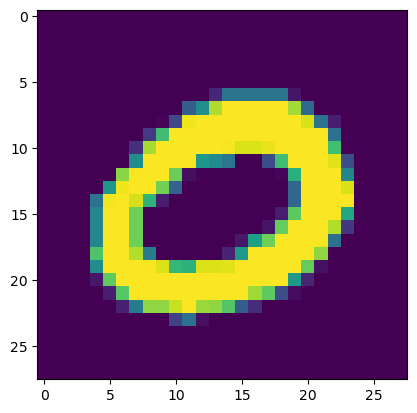

In [14]:
plt.imshow(mnist_vector.detach().numpy().T[6001].reshape(28,28))

In [15]:
def NN(x, thetas):
    W1, b1, W2, b2, W3, b3 = deflatten(thetas, get_shapes([W1_i, b1_i, W2_i,b2_i,W3_i, b3_i]))
    out = W3 @ torch.nn.LeakyReLU()(W2 @ torch.nn.LeakyReLU()(W1 @ x + b1) + b2) + b3
    return out

In [20]:
W1_i = (torch.rand((256,784)).float() - 0.5)*2 # W(64, d = 28) 
b1_i = (torch.rand((256,1)).float() - 0.5)*2

W2_i = (torch.rand((256,256)).float() - 0.5)*2
b2_i = (torch.rand((256,1)).float() - 0.5)*2

W3_i = (torch.rand((10,256)).float() - 0.5)*2
b3_i = (torch.rand((10,1)).float() - 0.5)*2

In [21]:
# Creiamo la varietà
manifold = LevelSetManifold(g, dg, 1)
# Test del parametro manifold

theta = flatten([W1_i, b1_i, W2_i,b2_i,W3_i, b3_i])
theta = geoopt.ManifoldParameter(theta , manifold=manifold)
g(theta)

tensor(133968.9062, grad_fn=<PowBackward0>)

In [22]:
torch.norm(dg(theta))

tensor(1267.7810, grad_fn=<LinalgVectorNormBackward0>)

In [23]:
testX.shape

(10000, 28, 28)

In [24]:
print("\n\n")

# # Verifica che il parametro iniziale appartenga alla varietà
# assert manifold._check_point_on_manifold(theta.data), "Il punto iniziale non è sulla varietà"

def loss_fn(mnist_vector, theta):
    return torch.nn.CrossEntropyLoss()(NN(mnist_vector, theta).T, torch.Tensor(trainy[quale]).long())

# Ottimizzatore Riemanniano
optimizer = RiemannianSGD([theta], lr=0.005)

# Ciclo di ottimizzazione
g_during_train = []
loss_history = []
acc_history = []
inv_history = []
test_acc_history = []
test_loss_history = []

print("############## Training phase ################")
for epoch in range(1500):
    outputs = NN(mnist_vector,theta)
    _, predicted = torch.max(outputs.data, 0)
    correct = (predicted == torch.Tensor(trainy[quale])).sum().item()
    outputs_val = NN(torch.Tensor(testX).reshape(10000,784).T,theta)
    _, predicted_val = torch.max(outputs_val.data, 0)
    correct_val = (predicted_val == torch.Tensor(testy)).sum().item()
    
    _, pred_90 = torch.max(NN(mnist_vector_rotated_90, theta), 0)
    _, pred_180 = torch.max(NN(mnist_vector_rotated_180, theta), 0)
    _, pred_270 = torch.max(NN(mnist_vector_rotated_270, theta), 0)
    
    inv1 = (predicted == pred_90).sum().item()
    inv2 = (predicted == pred_180).sum().item()
    inv3 = (predicted == pred_270).sum().item()
    
    inv = (inv1 + inv2 + inv3)/(3*len(quale))
    
    acc = correct/len(quale)
    acc_val = correct_val/len(testX)
    optimizer.zero_grad()
    loss = loss_fn(mnist_vector, theta)
    loss.backward()
    optimizer.step()
    if epoch%50 == 0:
        print("Epoch",  epoch + 1, "\n",
              "Loss:", loss.item(), "\n",
              "Acc:", acc, "\n",
              "g(theta):", round(float(g(theta).data.numpy()),15), "\n",
              "Invariance: ", inv, "\n",
             "Validation Acc: ", acc_val, "\n",
             )
        
    loss_history.append(loss.item())
    g_during_train.append(g(theta).data.numpy())
    acc_history.append(acc)
    inv_history.append(inv)
    test_acc_history.append(acc_val)
    
    if epoch > 1000:
        optimizer = RiemannianSGD([theta], lr=0.0005)
    
# plt.plot(g_during_train)
plt.plot(acc_history, label = "acc")
plt.plot(np.array(loss_history)/np.max(loss_history), label = "loss")
plt.plot(inv_history, label = "Inv")
plt.plot(test_acc_history, label = "val_accuracy")
plt.legend()
print("\n\n")

# Risultato finale
print("Punto finale:", theta)
print("Appartiene alla varietà?", manifold._check_point_on_manifold(theta))




############## Training phase ################
Epoch 1 
 Loss: 406.820068359375 
 Acc: 0.07676666666666666 
 g(theta): 2.685795e-09 
 Invariance:  0.42780555555555555 
 Validation Acc:  0.0788 

Epoch 51 
 Loss: 29.864673614501953 
 Acc: 0.43816666666666665 
 g(theta): 7.517904e-09 
 Invariance:  0.9999777777777777 
 Validation Acc:  0.4118 

Epoch 101 
 Loss: 21.477096557617188 
 Acc: 0.49743333333333334 
 g(theta): 4.253737e-09 
 Invariance:  0.9999777777777777 
 Validation Acc:  0.4614 

Epoch 151 
 Loss: 17.6823787689209 
 Acc: 0.5245166666666666 
 g(theta): 3.029218e-09 
 Invariance:  0.9999944444444444 
 Validation Acc:  0.4736 

Epoch 201 
 Loss: 15.419507026672363 
 Acc: 0.5433833333333333 
 g(theta): 9.103485e-09 
 Invariance:  1.0 
 Validation Acc:  0.4867 

Epoch 251 
 Loss: 14.522480010986328 
 Acc: 0.5541166666666667 
 g(theta): 2.780902e-09 
 Invariance:  0.9999944444444444 
 Validation Acc:  0.4928 

Epoch 301 
 Loss: 12.63504695892334 
 Acc: 0.5721833333333334 
 g(th

KeyboardInterrupt: 

In [32]:
outputs = NN(mnist_vector,theta)
_, predicted = torch.max(outputs.data, 0)
correct = (predicted == torch.Tensor(trainy[quale])).sum().item()
acc = correct/len(quale)
print(acc)

0.4949


In [38]:
_, prediction = torch.max(NN(mnist_vector,theta), 0) #
count_6 = 0
count_9 = 0
count_other = 0

for x,y in zip(prediction, trainy[quale]):
    if (y==9) and (x==6):
        count_6 = count_6 + 1
    elif (y==6) and (x==9):
        count_9 = count_9 + 1
    elif (y!=x):
        count_other = count_other +1
    #print(x,y)
        
print("6:" , count_6)
print("9:" , count_9)
print("other:" , count_other)
print("correct: ", len(quale) - count_6- count_9- count_other)

6: 108
9: 239
other: 4704
correct:  4949


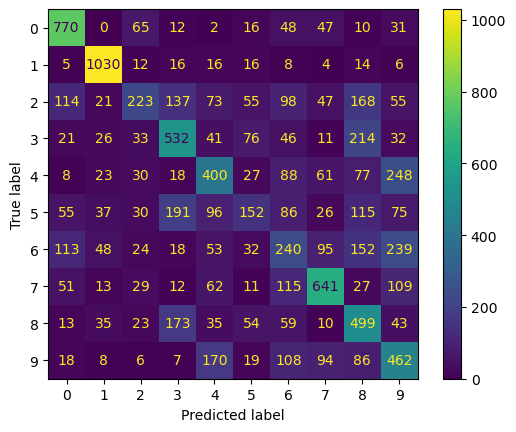

In [40]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split


predictions = prediction
cm = confusion_matrix(trainy[quale], predictions, labels=range(10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=range(10))
disp.plot()
plt.show()

In [15]:
NN(mnist_vector, theta).T[8]

tensor([-11.7272,   0.6615,  -5.3048,  -4.0545,  -7.9079,  -2.5445,  -2.5094,
         -8.4527,  -6.6200,  -8.7099], grad_fn=<SelectBackward0>)

In [16]:
NN(mnist_vector_rotated_90, theta).T[8]

tensor([-11.7271,   0.6614,  -5.3048,  -4.0545,  -7.9078,  -2.5445,  -2.5094,
         -8.4526,  -6.6200,  -8.7098], grad_fn=<SelectBackward0>)

In [17]:
NN(mnist_vector_rotated_180, theta).T[8]

tensor([-11.7271,   0.6614,  -5.3048,  -4.0545,  -7.9078,  -2.5445,  -2.5094,
         -8.4527,  -6.6200,  -8.7098], grad_fn=<SelectBackward0>)

In [18]:
NN(mnist_vector_rotated_270, theta).T[8]

tensor([-11.7272,   0.6614,  -5.3048,  -4.0545,  -7.9079,  -2.5445,  -2.5094,
         -8.4527,  -6.6200,  -8.7099], grad_fn=<SelectBackward0>)

In [19]:
W1, b1, W2, b2 = deflatten(theta, get_shapes([W1_i, b1_i, W2_i,b2_i]))

In [20]:
condition = W1.detach().numpy() @ (np.identity(28*28) -  G(28))
np.linalg.norm(condition)

8.893302545426792e-05

In [21]:
np.linalg.norm(condition @ np.random.randint(0,10,28*28))

0.00030582923142010116

In [22]:
np.linalg.norm(condition @ mnist_vector.detach().numpy().T[0])

3.4795479022061e-05

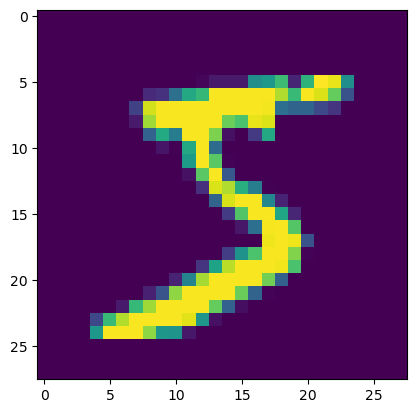

In [23]:
plt.imshow(mnist_vector.detach().numpy().T[0].reshape(28,28))

In [24]:
np.max(condition)

2.7418136596679688e-06

In [25]:
(W1.detach().numpy() @ mnist_vector.detach().numpy() )[0]

array([ 2.3589113 , -1.2392657 ,  0.74123764, ..., -1.582979  ,
        2.4336698 ,  2.1582737 ], dtype=float32)

In [26]:
(W1 @ torch.Tensor(G(28)) @ mnist_vector )[0]

tensor([ 2.3589, -1.2393,  0.7412,  ..., -1.5830,  2.4337,  2.1583],
       grad_fn=<SelectBackward0>)

In [27]:
W1.detach().numpy() @ G(28)

array([[-0.26163819, -0.15296951, -0.72599024, ..., -0.72598922,
        -0.15296903, -0.2616387 ],
       [ 0.33731684, -0.13450362,  0.22214191, ...,  0.22214143,
        -0.13450387,  0.33731633],
       [-0.316107  , -0.30446464,  0.21900624, ...,  0.21900672,
        -0.30446464, -0.31610751],
       ...,
       [ 0.03125081,  0.1607181 , -0.28720939, ..., -0.28720939,
         0.16071858,  0.03125071],
       [ 0.03378702,  0.04907757,  0.01136728, ...,  0.01136725,
         0.04907769,  0.03378696],
       [ 0.40228954, -0.07332046, -0.10033975, ..., -0.10033987,
        -0.07332022,  0.40228954]])

In [28]:
W1 @ mnist_vector @ mnist_vector[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<MvBackward0>)

In [29]:
W1 @ torch.Tensor(G(28))  @ mnist_vector

tensor([[ 2.3589, -1.2393,  0.7412,  ..., -1.5830,  2.4337,  2.1583],
        [-3.5733, -6.2788, -3.3779,  ..., -2.3481, -4.3122, -5.3346],
        [-3.9275, -4.4382, -1.6755,  ..., -0.9648, -2.6446, -2.1891],
        ...,
        [-1.2039, -2.8307, -0.2594,  ..., -6.1672, -3.5077, -5.7014],
        [ 2.1378,  4.8004,  2.8786,  ..., -0.4521,  2.4783,  0.9451],
        [ 0.0525, -2.1599, -1.0929,  ..., -2.1601,  1.3019, -4.1737]],
       grad_fn=<MmBackward0>)

In [30]:
(torch.Tensor(G(28))  @ mnist_vector.T[0] - mnist_vector_rotated_90[0]).norm()

RuntimeError: The size of tensor a (784) must match the size of tensor b (10000) at non-singleton dimension 0

In [ ]:
torch.nn.LeakyReLU()(W1 @ mnist_vector + b1)

In [ ]:
torch.nn.LeakyReLU()(W1 @ mnist_vector_rotated_90 + b1)

In [ ]:
thet = manifold.projx( theta)
W1_p, b1, W2, b2 = deflatten(thet, get_shapes([W1_i, b1_i, W2_i,b2_i]))

In [ ]:
np.linalg.norm((W1.detach().numpy() @ (np.identity(28*28) -  G(28))))

In [ ]:
np.linalg.norm(W1_p.detach().numpy() @ (np.identity(28*28) -  G(28)))

In [ ]:
W1 @ mnist_vector_rotated_180

In [ ]:
W1 @ mnist_vector_rotated_90

In [ ]:
W1, b1, W2, b2 = deflatten(thetas, get_shapes([W1_i, b1_i, W2_i,b2_i]))
out = W2 @ torch.nn.LeakyReLU()(W1 @ x + b1) + b2

In [ ]:
torch.nn.LeakyReLU()(W1 @ mnist_vector_rotated_90 + b1)

In [ ]:
torch.nn.LeakyReLU()(W1 @ mnist_vector + b1)

In [ ]:
W1_p @ mnist_vector

In [ ]:
W1_p @ mnist_vector_rotated_90